
<h1> Masters Project - Gender balancing via synthetic data </h1>

<p> This project is split into 3 parts, synth data generation, Decison trees and finally results. The first two will be in this code base while the third is currnetly located in a seperate file </p>

<p> While work on the main project has finished I am making a push to publish and want to make a few changes to make this piece of work beyond reproach. The main concern in reproducibility and the contents of tests. The inital version was quite messy so I will also be attempting to clean this up.  </p>


<h2> Part one - Synth data creation </h2>

<p> This needs to take a data set and create a model to generate data and save it to a file for later useage. </p>

<p> Initally this was planned to be achived manually with numpy but proved to be unreliabile and slow at best. As refining this would take a while the Synthetic data vault library.   </p>

<h3> TODO </h3>

 <p>   - Split tests so that a test set exists with the original data </p>
  <p>  - Also Have an all synth test set and training set </p>
  <p>  - Automate all this testing - so results are printed </p>

In [1]:
#Results automation 

#1 - printing to the same file, use string at front to show what model and test sets 
# 4 models , O = Original, G = Gender Balances, M = Male, F = Female 
# 4 Test sets - Always write in the same order - neutral, male, femal and GB
# Need a name for each dataset - Numbered 1-12

# So Possible text file line 1 = 1 O [neutral results]......[]

f = open("/Users/alextaylor/Desktop/Pro_DS/Reg/results.txt", "a")
f.write('Results go here \n')
f.close()

In [2]:
#imports
import numpy as np
import sdgym
import pandas as pd
import sdv
from sklearn.metrics import f1_score
from sdv.metrics.tabular import CSTest, KSTest
import math
from sdv.tabular import GaussianCopula as gaussCop
from sdv.tabular import CopulaGAN
from sdv.constraints.tabular import Positive
from sdv.constraints import GreaterThan
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics


#Globals - Variables that need to be changed every iteration 
dataSet_num = '1'
path = '/Users/alextaylor/Desktop/Pro_DS/Reg/hung.csv'
empty = '?'
gender = 'gender'
g_male = 1
g_female = 0
target = 13



In [14]:
#Methods to vectorise and replace emtpy entries

def vectorise(df):
    new_data = {}
    empty = '?'
    for(name,data) in df.iteritems():

        if type(data[0]) == str:
            uni = (data.str.split(';\s*', expand=True).stack().unique())
            reformed = []
            for i in data:
                if i == empty:
                    reformed.append('')
                else:
                    reformed.append(list(uni).index(i))

            new_data[name] = reformed
        else:
            new_data[name] = data

    new_data_df = pd.DataFrame(new_data)
    return(new_test_df)

def fill(df):
    new_data = {}
    for(name,data) in df.iteritems():
        x = data.to_numpy()
  
        index = 0
        total = 0
        length = 0
        
        for i in x.tolist():
            if type(i) is float:
                
                decimal_to_int = i*10
                
                x[index] = int(round(decimal_to_int))
                
                total += x[index]
                length +=1
            
            elif type(i) is int:
                if not i == '': 
                    if math.isnan(i):
                        x[index] = 0
                    total += x[index]
                length +=1
            if type(i) != str:    
                if math.isnan(i):
                    x[index] = 0
            index +=1  
        average = round(total/length)
        
        x = np.where(x == '', average, x)
        
        new_data[name] = x
        
    return(pd.DataFrame(new_data))

In [15]:
#ds = pd.read_csv('/Users/alextaylor/Desktop/heart.csv')
con_need = []

#read in DS
ds = pd.read_csv(path)

#Vectorise words and then fill in gaps 
ds = fill(vectorise(ds))

for(name,data) in ds.iteritems():
    if data.dtype == 'float64':
        ds[name] = data.astype(np.int64)
        #Save the name as a constraint is required! 
        con_need.append(name)

print(len(ds))

ds_m = ds[ds[gender] ==g_male]
ds_w = ds[ds[gender] ==g_female]

#Generate test sets for all real data
ds_m_np = ds_m.to_numpy()
ds_w_np = ds_w.to_numpy()

m_cut = int(round(len(ds_m_np)/100 *30, 0))
w_cut = int(round(len(ds_w_np)/100 *30, 0))

print(w_cut)

ds_test_or_w = ds_w_np[0:w_cut]
ds_test_or_m = ds_m_np[0:m_cut]

#Also need to keep these hidden so the orinals are only the last 70%
ds_w = pd.DataFrame(ds_w_np[w_cut:len(ds_w_np)])
ds_m = pd.DataFrame(ds_m_np[m_cut:len(ds_m)])

ds_m = ds_m.rename(columns={1: "gender"})
ds_w = ds_w.rename(columns={1: "gender"})


294
24


<ipython-input-14-be4d1eadf3e9>:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  x = np.where(x == '', average, x)


In [16]:
# Now generate synth data from this list 

#ds_w = women only -
#ds_m = men only   - All have the same amount of data
#gb_data = mixed   -
 
#Neg check here to ensure taht synth data is correct 
def neg_check(data_set):
        
    for (name,data) in gb_data.iteritems():
        for i in data:
            if i < 0:
                return name

non_neg = Positive(
        columns = int(con_need[0]),
        strict= False,
        handling_strategy='reject_sampling'
    )

con = [non_neg]

field_distributions = {
    'capital-gain': 'gamma',
    'capital-loss': 'gamma'
}

#commented out cons for some final tests 
syn_model = CopulaGAN(field_distributions=field_distributions, constraints=con)

#Need the same amount of data so take the total and div by two, 
total_needed = int(len(ds)/2)

print(total_needed)
print(len(ds_w))

if len(ds_w) < total_needed:
    #male dominated
    gb_data = ds_m[0:total_needed]
    print('male dominated - Fitting for female data')
    syn_model.fit(ds_w)
    
    print('female data fitted now generating for GB and fem data sets')
    print(total_needed)
    print(len(ds_w))
    gb_data = gb_data.append(ds_w.append(syn_model.sample(total_needed - len(ds_w))))
    
    #Need the all female ds to be equal size of the total data
    diff = len(ds) - len(ds_w)
    
    ds_w = ds_w.append(syn_model.sample(diff))
    #Need the all male ds to be equal to the size of the total data
    
    print('fitting male data')
    syn_model.fit(ds_m)
    diff = len(ds) - len(ds_m)

    ds_m = ds_m.append(syn_model.sample(diff))
    
    
else:
    
    print('female dominated - fitting for male data')
    gb_data = ds_w[0:total_needed]
    #Female dominated test set
    syn_model.fit(ds_m)
    gb_data = gb_data.append(ds_m.append(syn_model.sample(total_needed - len(ds_m))))
    
    #Need the all female ds to be equal size of the total data
    diff = len(ds) - len(ds_m)
    
    ds_m = ds_m.append(syn_model.sample(diff))
    #Need the all male ds to be equal to the size of the total data
    print('fitting for male data')
    syn_model.fit(ds_w)
    diff = len(ds) - len(ds_w)

    ds_w = ds_w.append(syn_model.sample(diff))
    
#Need the all female ds to be equal size of the total data    
print(len(ds_w))
print(len(ds_m))

#print(CSTest.compute(ds, gb_data))

#Next run try to keep the origonal data

if(len(gb_data[gb_data[gender] ==g_male]) == len(gb_data[gb_data[gender] ==g_female]) ):
    print('dataset has been gender balanced')
else:
    print('data not gender balanced')
    print(len(gb_data[gb_data[gender] ==g_male]))
    print(len(gb_data[gb_data[gender] ==g_female]))


2022-01-17 12:35:48,860 : MainThread : INFO : Fitting table None metadata
2022-01-17 12:35:48,868 : MainThread : INFO : Anonymizing table None
2022-01-17 12:35:48,869 : MainThread : INFO : Fitting constraints for table None
2022-01-17 12:35:48,877 : MainThread : INFO : Fitting HyperTransformer for table None


147
57
male dominated - Fitting for female data


2022-01-17 12:36:41,426 : MainThread : INFO : Fitting table None metadata
2022-01-17 12:36:41,429 : MainThread : INFO : Anonymizing table None
2022-01-17 12:36:41,430 : MainThread : INFO : Fitting constraints for table None
2022-01-17 12:36:41,437 : MainThread : INFO : Fitting HyperTransformer for table None


female data fitted now generating for GB and fem data sets
147
57
fitting male data
294
294
dataset has been gender balanced


In [158]:
print(gb_data[9])

#Check the data here. 
total = 0
leng = 0

for i in gb_data[9]:
    if type(i) != np.int64:
        print(i)
    total += i
    leng +=1


0      0
1      0
2      0
3     10
4      0
      ..
85     0
86     0
87     0
88     0
89     0
Name: 9, Length: 294, dtype: object
0
0
0
10
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
30
0
0
20
0
0
0
10
0
0
0
10
0
0
0
0
0
0
5
0
0
10
0
0
0
0
0
0
0
10
0
0
0
0
10
15
0
0
30
15
0
0
25
10
0
10
20
0
0
10
10
15
0
20
10
0
0
0
20
0
20
30
10
0
10
0
15
0
10
0
0
10
0
0
20
30
15
20
20
0
15
0
15
10
10
0
20
15
10
30
0
20
20
10
30
20
20
10
10
20
10
10
20
40
0
15
15
0
20
20
15
20
20
0
0
20
10
30
20
0
30
0
20
50
25
20
25
0
0
0
10
20
20
0
0
0
20
0
10
0
0
0
0
0
10
0
0
20
5
0
0
0
15
0
20
0
10
0
15
0
0
0
0
0
0
0
0
10
8
10
10
0
10
10
0
10
15
20
0
15
10
20
0
10
0
0
10
10
10
0
20
0
20
10
15
20
15
20
15
0
0
15
10
0
8
0
10
20
15
0
0
0
10
0
0
0
10
0
0
20
0
20
20
10
10
10
20
0
10
15
0
0
10
0
10
0
0
0
20
0
10
20
0
10
15
0
15
10
10
0
20
20
10
0
0
0
20
0
15
0
15
10
0
0
0
0
0
15
0
0
0
0
0
0


In [6]:
for (name,data) in gb_data.iteritems():
        for i in data:
            if i < 0:
                print(name)
                print(i)

In [20]:
print(gb_data)

print(ds_w)


     0 gender  2   3    4  5  6   7  8   9 10 11 12
0   48      1  3   6   20  0  1  23  0   0  1  1  1
1   49      1  2   4   69  0  1  40  0   0  1  1  2
2   49      1  3   2   70  0  1  11  0   0  1  1  2
3   49      1  4   1   27  0  1  21  0  10  1  1  2
4   49      1  4   2   66  0  1  12  0   0  1  1  2
..  ..    ... ..  ..  ... .. ..  .. ..  .. .. .. ..
85  48      0  2   1   54  0  1  37  0  20  1  1  3
86  51      0  3  18   14  0  2   2  0   0  1  1  2
87  62      0  3   1   66  0  0  37  1   0  2  1  2
88  53      0  2   7  125  0  1  44  0   5  1  1  2
89  58      0  2   0   76  0  2   3  1  10  1  1  2

[294 rows x 13 columns]
      0 gender  2   3    4  5  6   7  8   9 10 11 12 13
0    45      0  2  16   66  0  1   9  0   0  1  1  2  0
1    45      0  4  17   27  0  1  26  0   0  1  1  2  0
2    46      0  4   0   58  0  1  38  0   0  1  1  2  0
3    47      0  2   2   63  0  1  35  0  10  2  1  2  0
4    47      0  3   0   66  0  1  18  0  20  1  1  2  0
..   ..    ... 

In [21]:
#gb_target = gb_data[target]
#gb_data = gb_data.drop(target,axis = 1)

#old_tar = ds[str(target - 1)]
#ds= ds.drop(str(target-1),axis = 1)

w_target = ds_w[(target)]
ds_w= ds_w.drop(target,axis = 1)

m_target = ds_m[target]
ds_m = ds_m.drop(target,axis = 1)

gb_xtrain,gb_xtest,gb_ytrain,gb_ytest = train_test_split(gb_data,gb_target,shuffle = True)
nb_xtrain,nb_xtest,nb_ytrain,nb_ytest = train_test_split(ds,old_tar,shuffle = True)
w_xtrain,w_xtest,w_ytrain,w_ytest = train_test_split(ds_w,w_target,shuffle = True)
m_xtrain,m_xtest,m_ytrain,m_ytest = train_test_split(ds_m,m_target,shuffle = True)

In [22]:
orig_w = pd.DataFrame(ds_test_or_w)
orig_m = pd.DataFrame(ds_test_or_m)

orig_w_gen = orig_w[1] 
orig_m_gen = orig_m[1] 

orig_w_ans = orig_w[13]
orig_m_ans = orig_m[13]

orig_w = orig_w.drop(1,axis = 1)
orig_m = orig_m.drop(1,axis = 1)

orig_w = orig_w.drop(13,axis = 1)
orig_m = orig_m.drop(13,axis = 1)

mixed_test = orig_w.append(orig_m)


In [23]:
mixed_test = orig_w.append(orig_m)
mixed_ans = orig_w_ans.append(orig_m_ans)
mixed_gen = orig_w_gen.append(orig_m_gen)

In [24]:
#So spliting geneder from the ds, but will still need it to reference later

models_gen = [[gb_xtrain,gb_ytrain],[nb_xtrain,nb_ytrain],[w_xtrain,w_ytrain],[m_xtrain,m_ytrain]]
gb_xtrain = pd.DataFrame(gb_xtrain).drop(gender,axis = 1).to_numpy()
nb_xtrain = pd.DataFrame(nb_xtrain).drop(gender,axis = 1).to_numpy()
w_xtrain = pd.DataFrame(w_xtrain).drop(gender,axis = 1).to_numpy()
m_xtrain = pd.DataFrame(m_xtrain).drop(gender,axis = 1).to_numpy()

models = [[gb_xtrain,gb_ytrain],[nb_xtrain,nb_ytrain],[w_xtrain,w_ytrain],[m_xtrain,m_ytrain]]
tests_gen = [[nb_xtest,nb_ytest],[w_xtest,w_ytest],[m_xtest,m_ytest],[gb_xtest,gb_ytest]]

gb_xtest = pd.DataFrame(gb_xtest).drop(gender,axis = 1).to_numpy()
nb_xtest = pd.DataFrame(nb_xtest).drop(gender,axis = 1).to_numpy()
w_xtest = pd.DataFrame(w_xtest).drop(gender,axis = 1).to_numpy()
m_xtest = pd.DataFrame(m_xtest).drop(gender,axis = 1).to_numpy()

tests = [[nb_xtest,nb_ytest],[w_xtest,w_ytest],[m_xtest,m_ytest],[gb_xtest,gb_ytest]]

#Use these list to loop over once created 


In [79]:
from sklearn.metrics import f1_score

def percent_total(results,answers,training,gens):
    index = 0
    correct = 0
    incorrect =0
    total = 0
    c_male = 0
    c_female = 0
    male = 0
    female = 0
    
    answers = answers.to_numpy()
    #target = target.to_numpy()
    #compare aginst the actual results]
    
    for i in results:
        total += 1
        if answers[index] == i:
            correct += 1
            if gens[index] == g_male:
                c_male +=1
                male+=1
            elif gens[index] == g_female:
                c_female +=1
                female +=1
        else:
            if gens[index] == g_male:
                male +=1
            elif gens[index] == g_female:
                female +=1
        index += 1
    tot = round((correct/total)*100,2)
    f1 = 100 #round(f1_score(answers, results, average='macro'),2) 
    ma = 0
    fem =0
    
    print(male)
    print(female)
    
    print('correct male : female')  
    if male == 0:
        
        fem = round(c_female/female*100,2)
        
        print("No male test cases :",(c_female/female*100),'%') 
        print(tot,',',f1,',','na',',',fem)
        
        f = open("/Users/alextaylor/Desktop/Pro_DS/Reg/results.txt", "a")
        f.write('{},{},{},{},'.format(tot,f1,ma,fem))  
        f.close()
        
        print('append')
        
    elif female == 0:
        
        fem = 0
        ma = round((c_male/male)*100,2)
        
        #print((c_male/male)*100 ,"% : No female test cases") 
        #print(tot,',',f1,',',ma,',','na')
        
        print('append')
        
        #Switch from printing out to saving in a file
        
        f = open("/Users/alextaylor/Desktop/Pro_DS/Reg/results.txt", "a")
        f.write('{},{},{},{},'.format(tot,f1,ma,fem))
        f.close()
        
    else:
        
        fem = round(c_female/female*100,2)
        ma = round((c_male/male)*100,2)
        
        #print((c_male/male)*100 ,"% :",(c_female/female*100),'%')    
        #print(tot, ',', f1,',',ma,',',fem)
        
        print('add')
        
        f = open("/Users/alextaylor/Desktop/Pro_DS/Reg/results.txt", "a")
        f.write('{},{},{},{},'.format(tot,f1,ma,fem))  
        f.close()
    
    

In [33]:
print((tests_gen[1][0]))

      0  gender  1   2   3  4  5   6  7   8  9 10 11
103  49       0  2  21  50  0  1  45  0   0  1  1  2
74   42       0  2   6  87  0  1   9  0   0  1  1  2
91   48       0  2   1  66  2  2  43  0   0  1  1  2
105  47       0  3   2  60  2  1   1  0  15  1  1  2
35   47       0  4   1  30  0  2  23  0   2  1  1  2
..   ..     ... ..  ..  .. .. ..  .. ..  .. .. .. ..
86   47       0  3   0  66  0  1  18  0  20  1  1  2
60   57       0  4  21  84  2  1  18  0   2  1  1  2
171  57       0  1   0  14  0  1  14  0  10  1  1  2
91   39       0  1   7  10  0  1   9  0   2  1  1  2
47   41       0  2   0  42  0  1   3  0   0  1  1  2

[74 rows x 13 columns]


In [231]:

print(mixed_test)
print(len(mixed_ans.to_numpy()))
print(len(mixed_gen.to_numpy()))

    0  2   3   4  5  6   7  8  9  10 11 12
0   30  1   3   3  0  2   2  0  0  1  1  1
1   31  2   4   4  0  2   3  0  0  1  1  2
2   32  2   5   5  0  1   4  0  0  1  1  2
3   34  2   0   9  0  1   7  0  0  1  1  2
4   35  1   1  12  0  2   0  0  0  1  1  2
..  .. ..  ..  .. .. ..  .. .. .. .. .. ..
59  47  2  13  64  0  1  40  0  0  1  1  2
60  47  4   2  65  2  1  41  1  0  1  1  2
61  48  2   4  66  0  1  44  0  0  1  1  2
62  48  2   0  42  0  1   1  0  0  1  1  2
63  48  2   2  58  0  1  32  0  0  1  1  2

[88 rows x 12 columns]
88
88


66    1
0     0
15    0
61    1
16    0
     ..
39    0
10    0
28    1
56    1
38    1
Name: 13, Length: 220, dtype: int64
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64
24
correct male : female
add


[None, 'gini', 'best']

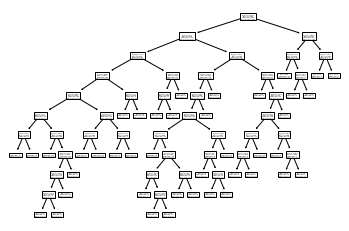

In [234]:
tree(gb_xtrain,gb_ytrain,mixed_test,mixed_ans.to_numpy(),mixed_gen.to_numpy())

In [75]:
dataSet_num = '1'
print((models[1][1]).to_numpy())

[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0
 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0]


In [26]:
#Create tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics

def model_create(x_train,y_train):
    
    clf = DecisionTreeClassifier(criterion = 'gini',splitter = 'best')
    x_train = pd.DataFrame(x_train)
    y_train=y_train.astype('int')
    return(clf.fit(x_train,y_train))
    
    


GB model
neutal test
[1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1
 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0]
57
17
correct male : female
add

female test
[0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1]
0
74
correct male : female
No male test cases : 62.16216216216216 %
62.16 , 100 , na , 62.16
append

male test
[0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0]
74
0
correct male : female
append

GB test
[0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1]
31
43
correct male : female
add

--------------
Neutral model
neutal test
[1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1
 1 1 1 0 0 0 0 0 1 1 1 0 1 

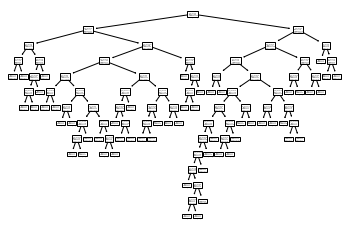

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
def tree(x_train,y_train,x_test,y_test,y_gen):
    
    #the results were always gini and best so going to stick with them 
    cri = ['gini'] #, 'entropy']
    splitter = ['best']#'random']
    best = 0

    for i in cri:
        for k in splitter:
            clf = DecisionTreeClassifier(criterion = i,splitter = k)
            x_train = pd.DataFrame(x_train)
            y_train=y_train.astype('int')
            
            clf = clf.fit(x_train,y_train)
            res = clf.predict(x_test)
            percent = percent_total(res,y_test,x_test,y_gen)

            if best == 0:
                best = [percent,i,k]
            elif percent > best[0]:
                best = [percent,i,k]
            
            plot_tree(clf)
            return best

index =0
test_index = 0
gender_index = 0

#Need to write the dataset to the file 
f = open("/Users/alextaylor/Desktop/Pro_DS/Reg/results.txt", "a")
f.write(dataSet_num)  
f.close()

for i in models:
    #loop over all the models then one set of tests for each model 
    if index == 0:
        print("GB model")
    elif index == 1:
        print('Neutral model')
    elif index == 2:
        print('female model')
    else:
        print('male model')
    for k in tests:
        if test_index == 0:
            print('neutal test')
            gender_index = 0
        elif test_index == 1:
            print('female test')
            gender_index = 1
        elif test_index ==2:
            print('male test')
            gender_index = 2
        else:
            print('GB test')
            gender_index = 3
        #run tree -xtrain,ytrain,x_test,y_test
        tree(i[0],i[1].to_numpy(),k[0],k[1],pd.DataFrame(tests_gen[gender_index][0])[gender].to_numpy())
        test_index +=1
        print('')
    f = open("/Users/alextaylor/Desktop/Pro_DS/Reg/results.txt", "a")
    f.write('\n')  
    f.close()
    print("--------------")
    index +=1
    test_index = 0

Here
correct male : female
92.6829268292683 % : 87.87878787878788 %
90.54 , 0.81 , 92.68 , 87.88


[None, 'gini', 'best']

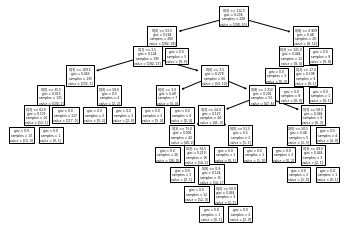

In [391]:
gb = models[1]
gb_test = tests[0]

tree(gb[0],gb[1],gb_test[0],gb_test[1],pd.DataFrame(tests_gen[3][0])[gender].to_numpy())

Here
correct male : female
92.6829268292683 % : 81.81818181818183 %
87.84 , 0.77 , 92.68 , 81.82


[None, 'gini', 'best']

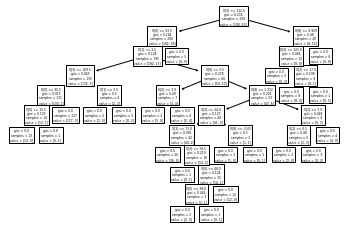

In [392]:
gb = models[0]
gb_test = tests[3]

tree(gb[0],gb[1],gb_test[0],gb_test[1],pd.DataFrame(tests_gen[3][0])[gender].to_numpy())